In [2]:
import tensorflow as tf
import pickle
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
from xml.etree import ElementTree as ETree
import pandas as pd

# Load data

In [7]:
def parse_xml(xml_files):
    annots_info = []
    for xml_file in xml_files:
        root = ETree.parse(xml_file)
        filename = root.find('filename').text
        width = int(root.find('size')[0].text)
        height = int(root.find('size')[1].text)
        for member in root.findall('object'):
            label = member[0].text
            occulded = int(member[4].text)
            xmin, ymin, xmax ,ymax = [int(member[5][i].text) for i in range(4)]

            annots_info.append({
                'file_name': 'data/archive/images/' + filename,
                'label': label,
                'width': width,
                'height': height,
                'occculded': occulded,
                'coords': [xmin, ymin, xmax, ymax]
            })
    
    return pd.DataFrame(annots_info, columns=list(annots_info[0].keys()))

In [3]:
images = glob.glob('data/archive/images/*.png')
annots = glob.glob('data/archive/annotations/*.xml')

In [8]:
df = parse_xml(annots)

In [27]:
images_path = df['file_name'].values.tolist()
coords = df['coords'].values.tolist()

# Prepare data

In [100]:
def convert_data(image_path, image_coords):
    image_buffer = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(image_buffer)[:,:,:3] # Remove alpha channel from png image
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (224, 224))
    
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    xmin = image_coords[0] / w
    ymin = image_coords[1] / h
    xmax = image_coords[2] / w
    ymax = image_coords[3] / h
    
    return img, tf.convert_to_tensor([xmin, ymin, xmax, ymax], dtype=tf.float32)

In [101]:
dataset = tf.data.Dataset.from_tensor_slices((images_path, coords))
dataset = dataset.map(convert_data)
dataset = dataset.batch(64)
dataset = dataset.shuffle(df.shape[0])
dataset = dataset.cache()
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Build model

In [102]:
resnet = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet', include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(224, 224, 3))
)
resnet.trainable = False
embeddings = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)

# Fully connected layer
box_head = tf.keras.layers.Dense(512)(embeddings)
box_head = tf.keras.layers.Activation('relu')(box_head)
box_head = tf.keras.layers.Dense(256)(box_head)
box_head = tf.keras.layers.Activation('relu')(box_head)
box_head = tf.keras.layers.Dense(4)(box_head)
box_head = tf.keras.layers.Activation('sigmoid')(box_head)

model = tf.keras.Model(inputs=resnet.input, outputs=box_head)

In [103]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [104]:
model.compile(
    loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

In [105]:
history = model.fit(
    dataset, epochs=10
)

Epoch 1/10
64/64 [==============================] - 9s 145ms/step - loss: 0.1454
Epoch 2/10
64/64 [==============================] - 9s 139ms/step - loss: 0.1403
Epoch 3/10
64/64 [==============================] - 9s 139ms/step - loss: 0.1385
Epoch 4/10
64/64 [==============================] - 9s 140ms/step - loss: 0.1371
Epoch 5/10
64/64 [==============================] - 9s 138ms/step - loss: 0.1360
Epoch 6/10
64/64 [==============================] - 9s 141ms/step - loss: 0.1351
Epoch 7/10
64/64 [==============================] - 9s 140ms/step - loss: 0.1343
Epoch 8/10
64/64 [==============================] - 9s 140ms/step - loss: 0.1337
Epoch 9/10
64/64 [==============================] - 9s 138ms/step - loss: 0.1332
Epoch 10/10
64/64 [==============================] - 9s 141ms/step - loss: 0.1327


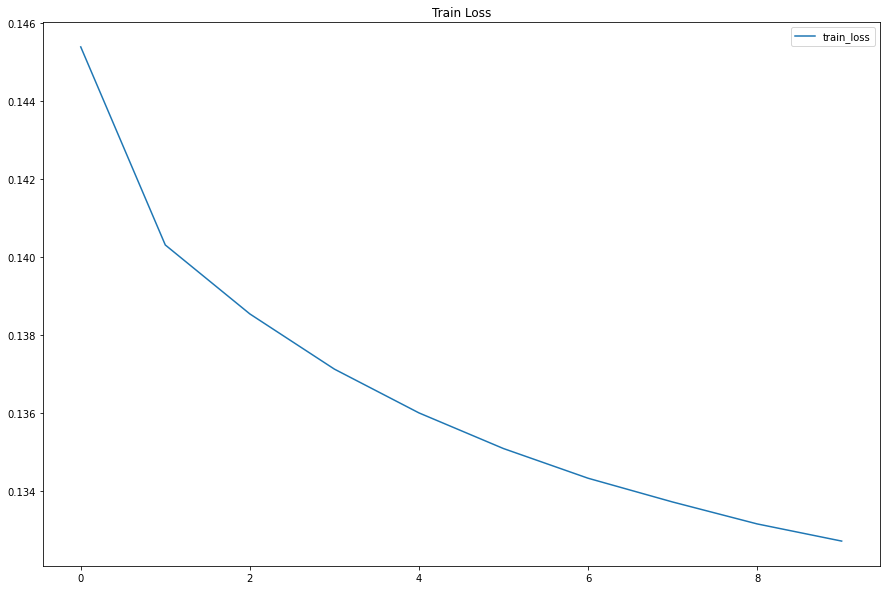

In [109]:
plt.figure(figsize=(15, 10))
plt.title('Train Loss')
plt.plot(history.history['loss'], label='train_loss')

plt.legend()

# Evaluate model